<a href="https://colab.research.google.com/github/HSAkash/Cauliflower-disease/blob/main/Cauliflower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle link
[Cauliflower Dataset](https://www.kaggle.com/datasets/noamaanabdulazeem/cauliflower-dataset/code)

## Import kaggle and auth
* Colab
* Jupyter notebook

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
# kaggle auth json file (kaggle.json)
!cp "kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Download data from kaggle

In [ ]:
! kaggle datasets download -d noamaanabdulazeem/cauliflower-dataset

# Coding
* Data split (train, test)
* Data scaling and augmentaion
* EfficientNetB0 model
* Finetuning base model:
  * layer: 202 - 236
  * Last 5 layer trainable after every 20 epoch
  * lr: lr *= 0.9 (every 20 epoch later)


## Data

### Set image path

In [2]:
datasets_dir = "/content/Original Dataset"

## For kaggle
# datasets_dir = "../input/cauliflower-dataset/Original Dataset"

### Load data from directory
* Split data set into train and test dataset

In [3]:
import tensorflow as tf
tf.random.set_seed(42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names

Found 656 files belonging to 4 classes.
Using 525 files for training.
Found 656 files belonging to 4 classes.
Using 131 files for validation.


['Bacterial spot rot', 'Black Rot', 'Downy Mildew', 'No disease']

### Data augmentation

In [4]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

### Visualize data

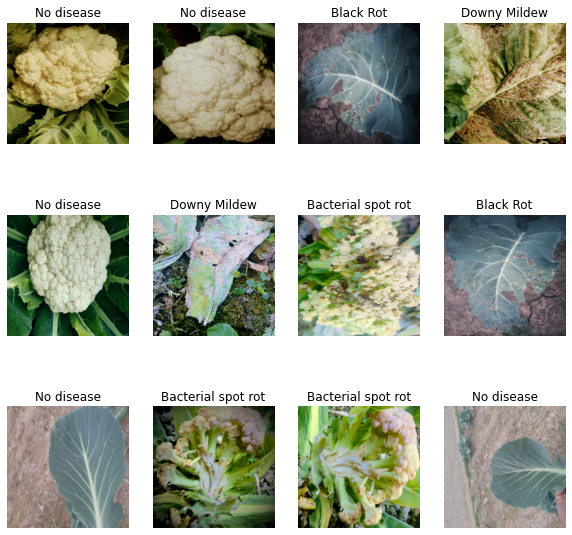

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"""
ploting image
"""

plt.figure(figsize=(10,10))
"""
Take only one batch
Each batch size is now 32
so Every batch has 32 images
"""
for image_batch,label_batch in train_data.take(1):
    """Ploting only 8 pictures of them"""
    for i in range(0,12):
        """Subploting them 3 rows and 4 columns"""
        plt.subplot(3,4,i+1)
        """Image data 0-255"""
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

## Create CheckPoint

In [ ]:
checkpoint_path = "/CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

## Create model

In [5]:
import tensorflow as tf

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

#Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


### Summary 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable

## Check model layer trainable or not

In [ ]:
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_avg_pooling_layer True
4 output_layer True


#### Base model layer (trainable)

In [ ]:
# for layer_number, layer in enumerate(model.layers[2].layers):
#   print(layer_number, layer.name, layer.trainable)

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## Fine tune

### Take 6 steps (1-6)

In [ ]:
import math
import time
# base_model_layer_len = math.ceil(len(base_model.layers)/5)

initial_epoch = 0
total_epoch = 20
learning_rate = 0.001
histories = []
steps = 7
for i in range(1, steps):
    model.compile(
        loss='categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ['accuracy']
    )
    history = model.fit(
        train_data,
        epochs= total_epoch,
        steps_per_epoch= len(train_data),
        validation_data=test_data,
        validation_steps=len(test_data),
        callbacks=[
            checkpoint_callback
        ],
        initial_epoch=initial_epoch
    )
    for layer in base_model.layers[-5* i:]:
        layer.trainable = True
    initial_epoch += 20
    total_epoch += 20
    learning_rate *= 0.9

Epoch 1/20
17/17 [==============================] - 31s 835ms/step - loss: 1.0352 - accuracy: 0.5771 - val_loss: 0.7115 - val_accuracy: 0.6641
Epoch 2/20
17/17 [==============================] - 7s 383ms/step - loss: 0.6375 - accuracy: 0.7790 - val_loss: 0.5019 - val_accuracy: 0.8550
Epoch 3/20
17/17 [==============================] - 6s 338ms/step - loss: 0.4906 - accuracy: 0.8514 - val_loss: 0.4127 - val_accuracy: 0.8702
Epoch 4/20
17/17 [==============================] - 4s 240ms/step - loss: 0.3732 - accuracy: 0.9219 - val_loss: 0.3691 - val_accuracy: 0.8626
Epoch 5/20
17/17 [==============================] - 5s 276ms/step - loss: 0.3246 - accuracy: 0.9295 - val_loss: 0.3167 - val_accuracy: 0.9084
Epoch 6/20
17/17 [==============================] - 6s 319ms/step - loss: 0.2922 - accuracy: 0.9314 - val_loss: 0.2935 - val_accuracy: 0.9084
Epoch 7/20
17/17 [==============================] - 5s 273ms/step - loss: 0.2545 - accuracy: 0.9581 - val_loss: 0.2777 - val_accuracy: 0.9160
Epoch

### Take 7 step (7-13)

In [ ]:
import math
import time
# base_model_layer_len = math.ceil(len(base_model.layers)/5)

initial_epoch = 120
total_epoch = 140
learning_rate = 0.001
histories = []
steps = 14
for i in range(7, steps):
    model.compile(
        loss='categorical_crossentropy',
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ['accuracy']
    )
    history = model.fit(
        train_data,
        epochs= total_epoch,
        steps_per_epoch= len(train_data),
        validation_data=test_data,
        validation_steps=len(test_data),
        callbacks=[
            checkpoint_callback
        ],
        initial_epoch=initial_epoch
    )
    model.save(f"model/{i}.h5")
    for layer in base_model.layers[-5* i:]:
        layer.trainable = True
    initial_epoch += 20
    total_epoch += 20
    learning_rate *= 0.9

Epoch 121/140
17/17 [==============================] - 9s 220ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.0796 - val_accuracy: 0.9695
Epoch 122/140
17/17 [==============================] - 3s 153ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0857 - val_accuracy: 0.9771
Epoch 123/140
17/17 [==============================] - 2s 151ms/step - loss: 0.0135 - accuracy: 0.9981 - val_loss: 0.0836 - val_accuracy: 0.9771
Epoch 124/140
17/17 [==============================] - 3s 148ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.9771
Epoch 125/140
17/17 [==============================] - 2s 124ms/step - loss: 0.0119 - accuracy: 0.9981 - val_loss: 0.0810 - val_accuracy: 0.9771
Epoch 126/140
17/17 [==============================] - 2s 127ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.0842 - val_accuracy: 0.9771
Epoch 127/140
17/17 [==============================] - 3s 159ms/step - loss: 0.0114 - accuracy: 0.9981 - val_loss: 0.0828 - val_ac

## Evaluate model

In [ ]:
model.evaluate(train_data), model.evaluate(test_data)

5/5 [==============================] - 0s 51ms/step - loss: 0.0617 - accuracy: 0.9924


([0.018974218517541885, 0.9923809766769409],
 [0.06166102737188339, 0.9923664331436157])

## load best weight

In [ ]:
model.load_weights(checkpoint_path)

### Evaluate best weight

In [ ]:
model.evaluate(train_data), model.evaluate(test_data)

5/5 [==============================] - 0s 52ms/step - loss: 0.0623 - accuracy: 0.9924


([0.023809723556041718, 0.9904761910438538],
 [0.062285538762807846, 0.9923664331436157])

### Base model layer trainable

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## Predicting the values

#### Visualize prediction

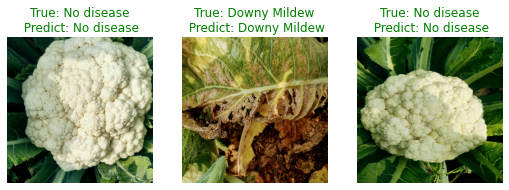

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

# Pretrain model weights

## Download weights from github

In [6]:
! wget https://github.com/HSAkash/Cauliflower-disease/raw/main/weights.zip && unzip weights.zip

--2022-08-15 13:47:32--  https://github.com/HSAkash/Cauliflower-disease/raw/main/weights.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Cauliflower-disease/main/weights.zip [following]
--2022-08-15 13:47:32--  https://raw.githubusercontent.com/HSAkash/Cauliflower-disease/main/weights.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15050680 (14M) [application/zip]
Saving to: ‘weights.zip’

weights.zip         100%[===================>]  14.35M  --.-KB/s    in 0.09s   

2022-08-15 13:47:33 (165 MB/s) - ‘weights.zip’ saved [15050680/15050680]

Archive:  weights.zip
   creating: wei

## Create bestWeight model


In [20]:
import tensorflow as tf

# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

#Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
best_weight_model = tf.keras.Model(inputs, outputs)

## Compile best_weight_model

In [21]:
best_weight_model.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

## Load pretrain weights

In [22]:
best_weight_model.load_weights("weights/cp.ckpt")

## Evaluate

### Train data

In [26]:
best_weight_model.evaluate(train_data)

17/17 [==============================] - 29s 2s/step - loss: 0.0250 - accuracy: 0.9924


[0.025021366775035858, 0.9923809766769409]

### Test data

In [27]:
best_weight_model.evaluate(test_data)

5/5 [==============================] - 6s 1s/step - loss: 0.0653 - accuracy: 0.9924


[0.06527866423130035, 0.9923664331436157]

## Prediction && visualize

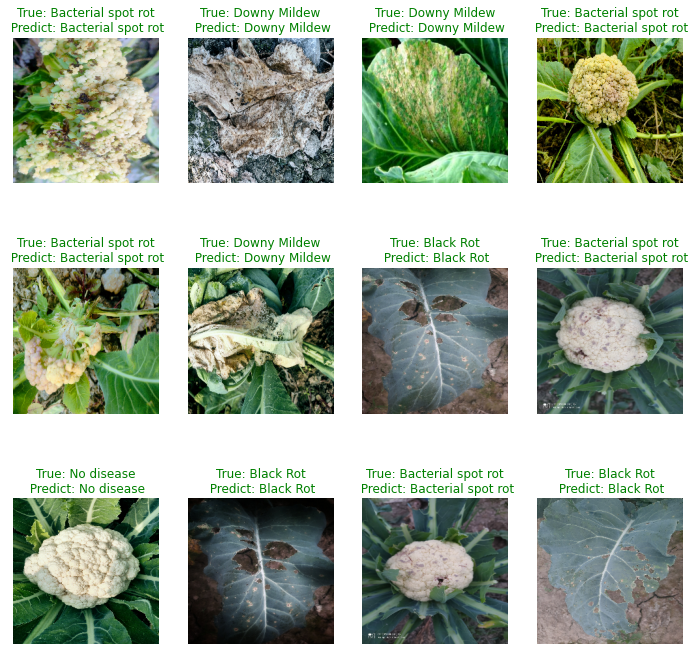

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = best_weight_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")